<h1>Introduction/Business Problem</h1>

The objective of this capstone project is to help the travelers of Tokyo city to choose the best restaurant that fits their needs since Tokyo is well-known as the restaurant capital of the world with over 160,000 places , using data science methodology and machine learning techniques especially clustering, this project aims to provide solutions for this problem

Foursquare’s slogan is “Foursquare helps you find the places you’ll love, anywhere in the world”. Since the launch of the Foursquare mobile app in 2009, Foursquare has helped 60 million users discover new exciting places worldwide [1]. The app provides personalized recommendations of places to visit in the vicinity of a user’s current location based on “previous browsing history, purchases, or check-in history”. [2] As a result, the Foursquare app has gained popularity for helping users to discover brand new places that match their interests. 
Using Foursquare API will help us collect the data that we need to resolve our Business Problem

<h1>Data section</h1>

For this project we need following data:<br>
Tokyo data that contains list districts (Wards) along with their latitude and longitude.<br>
We will Scrap Tokyo districts (Wards) Table from Wikipedia and get the coordinates of these 23 major districts using geocoder class of Geopy client.<br>
Restaurants in each neighborhood of Tokyo:<br>
Datasource : https://en.wikipedia.org/wiki/Special_wards_of_Tokyo#List_of_special_wards<br>
Description : By using this API we will get all the venues in each neighborhood. We can filter these venues to get only restaurants.

In [1]:
import numpy as np 
import pandas as pd 
from geopy.geocoders import Nominatim 
import seaborn as sns
from matplotlib import pyplot as plt


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors


In [2]:
df_initial = pd.read_html('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo#List_of_special_wards')[3]
df_initial.head()

,No.,Flag,Name,Kanji,Population(as of October 2016,Density(/km2),Area(km2),Major districts
0,01,NaN,Chiyoda,千代田区,59441,5100,11.66,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,..."
1,02,NaN,Chūō,中央区,147620,14460,10.21,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb..."
2,03,NaN,Minato,港区,248071,12180,20.37,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong..."
3,04,NaN,Shinjuku,新宿区,339211,18620,18.22,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich..."
4,05,NaN,Bunkyō,文京区,223389,19790,11.29,"Hongō, Yayoi, Hakusan"


In [3]:
df = df_initial[["Kanji","Name"]]
df.head()

,Kanji,Name
0,千代田区,Chiyoda
1,中央区,Chūō
2,港区,Minato
3,新宿区,Shinjuku
4,文京区,Bunkyō


In [4]:
geolocator = Nominatim(user_agent="Tokyo_explorer")

df['Major_Dist_Coord']= df['Kanji'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['Major_Dist_Coord'].apply(pd.Series)

df.drop(['Major_Dist_Coord'], axis=1, inplace=True)
df.drop(['Kanji'], axis=1, inplace=True)
df.head()

C:\Users\GOUTAIBABDERRAFII\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\GOUTAIBABDERRAFII\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\GOUTAIBABDERRAFII\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,Name,Latitude,Longitude
0,Chiyoda,35.693810,139.753216
1,Chūō,35.666255,139.775565
2,Minato,35.643227,139.740055
3,Shinjuku,35.693763,139.703632
4,Bunkyō,35.718810,139.744732


In [5]:
CLIENT_ID = 'MQ0XIFC4T5X5MCUWN1M3VZ011RFZQPP5JZ1AO02PIIWJZPN0' # your Foursquare ID
CLIENT_SECRET = 'DO3SU02BKYOAAVWOWC33O2I5QZNZLI1ULXDJSWE4A0CHR5S5' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)



In [7]:
Tokyo_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Chiyoda
Chūō
Minato
Shinjuku
Bunkyō
Taitō
Sumida
Kōtō
Shinagawa
Meguro
Ōta
Setagaya
Shibuya
Nakano
Suginami
Toshima
Kita
Arakawa
Itabashi
Nerima
Adachi
Katsushika
Edogawa
Overall


In [8]:
Tokyo_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chiyoda,35.69381,139.753216,Jimbocho Kurosu (神保町 黒須),35.695539,139.754851,Ramen Restaurant
1,Chiyoda,35.69381,139.753216,Nippon Budokan (日本武道館),35.693356,139.749865,Stadium
2,Chiyoda,35.69381,139.753216,Mori no Butchers (森のブッチャーズ),35.694770,139.755980,Gastropub
3,Chiyoda,35.69381,139.753216,Kitanomaru Park (北の丸公園),35.691653,139.751201,Park
4,Chiyoda,35.69381,139.753216,Shimizumon Gate (清水門),35.692685,139.752681,Historic Site


In [9]:
Tokyo_Venues_only_restaurant = Tokyo_venues[Tokyo_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
Tokyo_Venues_only_restaurant.index = np.arange(1, len(Tokyo_Venues_only_restaurant )+1)

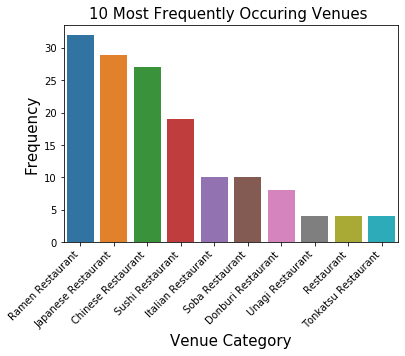

<Figure size 1296x504 with 0 Axes>

In [10]:


Tokyo_5_Dist_Venues_Top10 = Tokyo_Venues_only_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
Tokyo_5_Dist_Venues_Top10=Tokyo_5_Dist_Venues_Top10.reset_index()
#Tokyo_5_Dist_Venues_Top10

Tokyo_5_Dist_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)



s=sns.barplot(x="Venue_Category", y="Frequency", data=Tokyo_5_Dist_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Venues ', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()


In [11]:
Tokyo_Venues_restaurant = Tokyo_Venues_only_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())

In [12]:
Tokyo_Venues_restaurant_df  = Tokyo_Venues_restaurant.to_frame().reset_index()
Tokyo_Venues_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
Tokyo_Venues_restaurant_df.index = np.arange(1, len(Tokyo_Venues_restaurant_df)+1)
list_rest_no =Tokyo_Venues_restaurant_df['Number of Restaurant'].to_list()
list_dist =Tokyo_Venues_restaurant_df['Neighborhood'].to_list()

In [13]:
Tokyo_Venues_only_restaurant_top10 = pd.DataFrame()
list_of_venues_names = Tokyo_5_Dist_Venues_Top10['Venue_Category']
for i in range(0,len(list_of_venues_names)):
    Tokyo_Venues_only_restaurant_top10 = Tokyo_Venues_only_restaurant_top10.append(Tokyo_Venues_only_restaurant[Tokyo_Venues_only_restaurant['Venue Category'] == list_of_venues_names[i]])


In [14]:
Tokyo_Venues_only_restaurant_top10

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Chiyoda,35.693810,139.753216,Jimbocho Kurosu (神保町 黒須),35.695539,139.754851,Ramen Restaurant
5,Chiyoda,35.693810,139.753216,Fukumen Tomo (覆麺 智),35.696403,139.757070,Ramen Restaurant
7,Chiyoda,35.693810,139.753216,Yojinbo (用心棒),35.696409,139.756696,Ramen Restaurant
11,Chiyoda,35.693810,139.753216,Ramen Jiro (ラーメン二郎 神田神保町店),35.696390,139.756477,Ramen Restaurant
66,Sumida,35.700429,139.805017,ラーメン Sorenari,35.700927,139.810407,Ramen Restaurant
...,...,...,...,...,...,...,...
169,Adachi,35.783703,139.795319,ゆず庵 足立島根店,35.782345,139.799105,Restaurant
67,Sumida,35.700429,139.805017,特選とんかつ くり家,35.699004,139.809702,Tonkatsu Restaurant
86,Ōta,35.561206,139.715843,Tonkatsu Aoki (とんかつ檍),35.560463,139.716934,Tonkatsu Restaurant
101,Ōta,35.561206,139.715843,まるやま食堂,35.563816,139.717070,Tonkatsu Restaurant


In [15]:
# one hot encoding
Tokyo_onehot = pd.get_dummies(Tokyo_Venues_only_restaurant_top10[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
Tokyo_onehot['Neighborhood'] = Tokyo_Venues_only_restaurant_top10['Neighborhood'] 
Tokyo_onehot

,Chinese Restaurant,Donburi Restaurant,Italian Restaurant,Japanese Restaurant,Ramen Restaurant,Restaurant,Soba Restaurant,Sushi Restaurant,Tonkatsu Restaurant,Unagi Restaurant,Neighborhood
1,0,0,0,0,1,0,0,0,0,0,Chiyoda
5,0,0,0,0,1,0,0,0,0,0,Chiyoda
7,0,0,0,0,1,0,0,0,0,0,Chiyoda
11,0,0,0,0,1,0,0,0,0,0,Chiyoda
66,0,0,0,0,1,0,0,0,0,0,Sumida
...,...,...,...,...,...,...,...,...,...,...,...
169,0,0,0,0,0,1,0,0,0,0,Adachi
67,0,0,0,0,0,0,0,0,1,0,Sumida
86,0,0,0,0,0,0,0,0,1,0,Ōta
101,0,0,0,0,0,0,0,0,1,0,Ōta


In [16]:
Tokyo_grouped = Tokyo_onehot.groupby('Neighborhood').mean().reset_index()
Tokyo_grouped.head()

,Neighborhood,Chinese Restaurant,Donburi Restaurant,Italian Restaurant,Japanese Restaurant,Ramen Restaurant,Restaurant,Soba Restaurant,Sushi Restaurant,Tonkatsu Restaurant,Unagi Restaurant
0,Adachi,0.000000,0.000000,0.250000,0.250000,0.000000,0.5,0.000000,0.000000,0.0,0.0
1,Arakawa,0.285714,0.142857,0.142857,0.142857,0.285714,0.0,0.000000,0.000000,0.0,0.0
2,Bunkyō,0.500000,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.0,0.0
3,Chiyoda,0.454545,0.000000,0.090909,0.000000,0.363636,0.0,0.000000,0.090909,0.0,0.0
4,Chūō,0.000000,0.000000,0.105263,0.157895,0.000000,0.0,0.105263,0.631579,0.0,0.0


In [49]:
num_top_venues = 5

for hood in Tokyo_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Tokyo_grouped[Tokyo_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adachi----
                 venue  freq
0           Restaurant  0.50
1   Italian Restaurant  0.25
2  Japanese Restaurant  0.25
3   Chinese Restaurant  0.00
4   Donburi Restaurant  0.00


----Arakawa----
                 venue  freq
0   Chinese Restaurant  0.29
1     Ramen Restaurant  0.29
2   Donburi Restaurant  0.14
3   Italian Restaurant  0.14
4  Japanese Restaurant  0.14


----Bunkyō----
                 venue  freq
0   Chinese Restaurant   0.5
1  Japanese Restaurant   0.5
2   Donburi Restaurant   0.0
3   Italian Restaurant   0.0
4     Ramen Restaurant   0.0


----Chiyoda----
                venue  freq
0  Chinese Restaurant  0.45
1    Ramen Restaurant  0.36
2  Italian Restaurant  0.09
3    Sushi Restaurant  0.09
4  Donburi Restaurant  0.00


----Chūō----
                 venue  freq
0     Sushi Restaurant  0.63
1  Japanese Restaurant  0.16
2   Italian Restaurant  0.11
3      Soba Restaurant  0.11
4   Chinese Restaurant  0.00


----Edogawa----
                 venue  freq
0   It

In [50]:

#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [51]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Tokyo_grouped['Neighborhood']

for ind in np.arange(Tokyo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tokyo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(23)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adachi,Restaurant,Japanese Restaurant,Italian Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Ramen Restaurant,Donburi Restaurant,Chinese Restaurant
1,Arakawa,Ramen Restaurant,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Donburi Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Restaurant
2,Bunkyō,Japanese Restaurant,Chinese Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Restaurant,Ramen Restaurant,Italian Restaurant,Donburi Restaurant
3,Chiyoda,Chinese Restaurant,Ramen Restaurant,Sushi Restaurant,Italian Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Soba Restaurant,Restaurant,Japanese Restaurant,Donburi Restaurant
4,Chūō,Sushi Restaurant,Japanese Restaurant,Soba Restaurant,Italian Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Restaurant,Ramen Restaurant,Donburi Restaurant,Chinese Restaurant
5,Edogawa,Ramen Restaurant,Italian Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Restaurant,Japanese Restaurant,Donburi Restaurant,Chinese Restaurant
6,Itabashi,Restaurant,Chinese Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Ramen Restaurant,Japanese Restaurant,Italian Restaurant,Donburi Restaurant
7,Katsushika,Ramen Restaurant,Donburi Restaurant,Chinese Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Restaurant,Japanese Restaurant,Italian Restaurant
8,Kita,Ramen Restaurant,Japanese Restaurant,Soba Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Restaurant,Italian Restaurant,Donburi Restaurant,Chinese Restaurant
9,Kōtō,Chinese Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Restaurant,Ramen Restaurant,Japanese Restaurant,Italian Restaurant,Donburi Restaurant


In [52]:
# set number of clusters
kclusters = 5

Tokyo_grouped_clustering = Tokyo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 0, 2, 0, 3, 0, 4, 0, 0, 1])

In [53]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tokyo_merged = df

tokyo_merged.rename(columns={'Name':'Neighborhood'}, inplace=True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tokyo_merged = tokyo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

tokyo_merged.head() # check the last columns!

C:\Users\GOUTAIBABDERRAFII\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chiyoda,35.693810,139.753216,0.0,Chinese Restaurant,Ramen Restaurant,Sushi Restaurant,Italian Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Soba Restaurant,Restaurant,Japanese Restaurant,Donburi Restaurant
1,Chūō,35.666255,139.775565,3.0,Sushi Restaurant,Japanese Restaurant,Soba Restaurant,Italian Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Restaurant,Ramen Restaurant,Donburi Restaurant,Chinese Restaurant
2,Minato,35.643227,139.740055,3.0,Soba Restaurant,Japanese Restaurant,Chinese Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Italian Restaurant,Donburi Restaurant
3,Shinjuku,35.693763,139.703632,2.0,Japanese Restaurant,Unagi Restaurant,Chinese Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Restaurant,Ramen Restaurant,Italian Restaurant,Donburi Restaurant
4,Bunkyō,35.718810,139.744732,2.0,Japanese Restaurant,Chinese Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Restaurant,Ramen Restaurant,Italian Restaurant,Donburi Restaurant


In [65]:
tokyo_merged = tokyo_merged.dropna()
tokyo_merged['Cluster Labels']=tokyo_merged['Cluster Labels'].astype(int)
tokyo_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chiyoda,35.693810,139.753216,0,Chinese Restaurant,Ramen Restaurant,Sushi Restaurant,Italian Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Soba Restaurant,Restaurant,Japanese Restaurant,Donburi Restaurant
1,Chūō,35.666255,139.775565,3,Sushi Restaurant,Japanese Restaurant,Soba Restaurant,Italian Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Restaurant,Ramen Restaurant,Donburi Restaurant,Chinese Restaurant
2,Minato,35.643227,139.740055,3,Soba Restaurant,Japanese Restaurant,Chinese Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Italian Restaurant,Donburi Restaurant
3,Shinjuku,35.693763,139.703632,2,Japanese Restaurant,Unagi Restaurant,Chinese Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Restaurant,Ramen Restaurant,Italian Restaurant,Donburi Restaurant
4,Bunkyō,35.718810,139.744732,2,Japanese Restaurant,Chinese Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Restaurant,Ramen Restaurant,Italian Restaurant,Donburi Restaurant
5,Taitō,35.717450,139.790859,2,Japanese Restaurant,Sushi Restaurant,Unagi Restaurant,Chinese Restaurant,Tonkatsu Restaurant,Soba Restaurant,Restaurant,Ramen Restaurant,Italian Restaurant,Donburi Restaurant
6,Sumida,35.700429,139.805017,2,Japanese Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Ramen Restaurant,Chinese Restaurant,Unagi Restaurant,Soba Restaurant,Restaurant,Italian Restaurant,Donburi Restaurant
7,Kōtō,35.649154,139.812790,1,Chinese Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Soba Restaurant,Restaurant,Ramen Restaurant,Japanese Restaurant,Italian Restaurant,Donburi Restaurant
8,Shinagawa,35.599252,139.738910,3,Donburi Restaurant,Sushi Restaurant,Soba Restaurant,Restaurant,Japanese Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Ramen Restaurant,Italian Restaurant,Chinese Restaurant
9,Meguro,35.621250,139.688014,2,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Italian Restaurant,Unagi Restaurant,Tonkatsu Restaurant,Soba Restaurant,Restaurant,Ramen Restaurant,Donburi Restaurant


In [66]:
address = 'Tokyo'

geolocator = Nominatim(user_agent="Tokyo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


map_restaurants10 = folium.Map(location=[latitude,longitude], tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']
#Districts = ['Nagatacho', 'Nihonbashi', 'Shinjuku', 'Shinagawa', 'Shibuya']

# add markers to the map
for lat, lon, poi, cluster in zip(tokyo_merged['Latitude'], 
                                  tokyo_merged['Longitude'], 
                                  tokyo_merged['Neighborhood'], 
                                  tokyo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[list_dist.index(poi)]*0.5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10